# Hotel Recommendation System using Keras

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

import tensorflow as tf
from keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')
%matplotlib inline

In [55]:
hotel_train_data = pd.read_csv("..data\\train.csv", sep=',', nrows=150000)

In [56]:
hotel_train_data.head(2)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1


# Data Pre-processing

In [57]:
df = hotel_train_data[['user_id','hotel_cluster','is_booking']]

In [58]:
df = hotel_train_data[['user_id','hotel_cluster','is_booking']]

In [59]:
#I've renamed columns for my work
df.columns =['User_id', 'Item_id', 'Rating']
df.head()

,User_id,Item_id,Rating
0,12,1,0
1,12,1,1
2,12,1,0
3,93,80,0
4,93,21,0


In [60]:
df.shape

(150000, 3)

In [61]:
n_users = len(df.User_id.unique())
n_users

5142

In [62]:
n_books = len(df.Item_id.unique())
n_books

100

Create variables with the total number of unique users and item in the data, as well as the min and max ratings present in the data

In [63]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['User_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['item'] = item_enc.fit_transform(df['Item_id'].values)
n_items = df['item'].nunique()

df['rating'] = df['Rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])
n_users, n_items
print(min_rating, max_rating)

0.0 1.0


# Split the data into training and test data sets

In [64]:
X = df[['user', 'item']].values
y = df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((135000, 2), (15000, 2), (135000,), (15000,))

In [65]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Creating Neural Network

Neural Networks proved there effectivness for almost every machine learning problem as of now and they also perform exceptionally well for recommendation systems.

Embeddings are weights that are learned to represent some specific variable like items and user in our case and therefore we can not only use them to get good results on our problem but also to extract inside about our data.

In [66]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
   
    
# add fully-connected-layers
fc1 = Dense(128, activation='relu')(x)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

model = Model([user, item], out)
opt = Adam(lr=0.001)
model.compile(optimizer = opt, loss = 'mean_absolute_error', metrics=['accuracy'])

In [67]:
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 1, 50)        257100      input_13[0][0]                   
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 1, 50)        5000        input_14[0][0]                   
______________________________________________________________________________________

# Evaluation

There are many evaluation metrics but for this project we used, most popular metric to evaluate accuracy of predicted ratings are Root Mean Squared Error (RMSE) and Mean Absolute Error (MAE).

In [68]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
2110/2110 [==============================] - 9s 4ms/step - loss: 0.0862 - accuracy: 0.9168 - val_loss: 0.0843 - val_accuracy: 0.9164
Epoch 2/5
2110/2110 [==============================] - 8s 4ms/step - loss: 0.0836 - accuracy: 0.9168 - val_loss: 0.0838 - val_accuracy: 0.9164
Epoch 3/5
2110/2110 [==============================] - 9s 4ms/step - loss: 0.0834 - accuracy: 0.9168 - val_loss: 0.0838 - val_accuracy: 0.9164
Epoch 4/5
2110/2110 [==============================] - 8s 4ms/step - loss: 0.0834 - accuracy: 0.9168 - val_loss: 0.0839 - val_accuracy: 0.9164
Epoch 5/5
2110/2110 [==============================] - 9s 4ms/step - loss: 0.0834 - accuracy: 0.9168 - val_loss: 0.0837 - val_accuracy: 0.9164


## Creating RMSE function for Neural Network

In [69]:
def root_mean_squared_error(y_test, y_train):
        return K.sqrt(K.mean(K.square(y_test - y_train))) 

In [70]:
# creating user embedding
user = Input(shape=(1,))
u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
u = Reshape((n_factors,))(u)

# creating item embedding path
item = Input(shape=(1,))
i = Embedding(n_items, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(item)
i = Reshape((n_factors,))(i)
    
# concatenate features
x = Concatenate()([u, i])
     
# add fully-connected-layers
fc1 = Dense(128, activation='relu')(x)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

model = Model([user, item], out)
opt = Adam(lr=0.001)
model.compile(optimizer = opt , loss = root_mean_squared_error, metrics=['accuracy'])

In [71]:
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 1, 50)        257100      input_15[0][0]                   
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 50)        5000        input_16[0][0]                   
______________________________________________________________________________________

In [72]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/5
2110/2110 [==============================] - 8s 4ms/step - loss: 0.2671 - accuracy: 0.9168 - val_loss: 0.2680 - val_accuracy: 0.9164
Epoch 2/5
2110/2110 [==============================] - 8s 4ms/step - loss: 0.2623 - accuracy: 0.9168 - val_loss: 0.2698 - val_accuracy: 0.9164
Epoch 3/5
2110/2110 [==============================] - 8s 4ms/step - loss: 0.2610 - accuracy: 0.9168 - val_loss: 0.2700 - val_accuracy: 0.9163
Epoch 4/5
2110/2110 [==============================] - 8s 4ms/step - loss: 0.2599 - accuracy: 0.9167 - val_loss: 0.2722 - val_accuracy: 0.9163
Epoch 5/5
2110/2110 [==============================] - 8s 4ms/step - loss: 0.2581 - accuracy: 0.9166 - val_loss: 0.2747 - val_accuracy: 0.9166


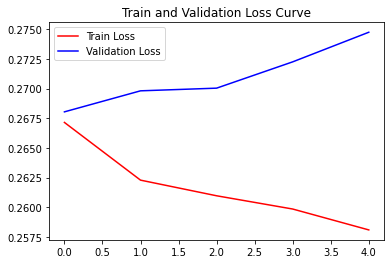

In [73]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss, color='r', label='Train Loss')
plt.plot(val_loss, color='b', label='Validation Loss')
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.show()

# Making Recommendations

In [74]:
# Creating dataset for making recommendations for the first user
hotel_data = np.array(list(set(df.Item_id)))
hotel_data[:5]

array([0, 1, 2, 3, 4])

In [75]:
user = np.array([1 for i in range(len(hotel_data))])
user[:5]

array([1, 1, 1, 1, 1])

In [76]:
predictions = model.predict([user, hotel_data])

predictions = np.array([a[0] for a in predictions])

recommended_item_ids = (-predictions).argsort()[:5]

recommended_item_ids

array([72, 49, 59, 19, 36], dtype=int64)

In [77]:
# print predicted scores
predictions[recommended_item_ids]

array([0.19043083, 0.18687372, 0.18581037, 0.18546915, 0.18278559],
      dtype=float32)

# Recommend Hotel Cluster for a User

In [99]:
rows = []
hotel = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)
names = list(df.drop_duplicates(subset='Item_id', keep='first').Item_id)

for i in range(len(hotel)):
    rows.append( dict({'name': names[i], 'Item_id' : hotel[i], 'User_id' : 1048}))
test_data = pd.DataFrame(rows)

In [100]:
for idx, (score, name) in enumerate(sorted(zip(recommended_item_ids, names), reverse=True)):
 
    print("Score: ", round(float(score), 2), " for hotel cluster: ", name)

Score:  72.0  for hotel cluster:  1
Score:  59.0  for hotel cluster:  21
Score:  49.0  for hotel cluster:  80
Score:  36.0  for hotel cluster:  41
Score:  19.0  for hotel cluster:  92
